In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# from matplotlib.animation import FuncAnimation
# from celluloid import Camera

# from matplotlib.animation import PillowWriter

# import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

import hdbscan
import seaborn as sns
from umap import UMAP


In [2]:
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["r", "k", "c"]) 
# plt.style.use('dark_background')

In [3]:
football, football_attributes = svg2paths("american-football.svg")
football_marker = parse_path(football_attributes[0]["d"])


# Cluster formations
1. Invert R to L plays
2. Line of scrimmage abs val xy coordinates
3. Shrink field
4. fill players on new field 

Offensive and Defensive formations for each play type (kickoff, punt, extra point, and field goal)
Maybe not extra point... due to 2p conversions

In [4]:
game_data = pd.read_csv("data/games.csv")
plays = pd.read_csv("data/plays.csv")
scouting = pd.read_csv("data/PFFScoutingData.csv")


In [5]:
punt_plays = plays[plays["specialTeamsPlayType"] == "Punt"].copy()


In [6]:
# merge game data
punt_plays = punt_plays.merge(game_data, left_on="gameId", right_on="gameId")

In [7]:
# merge game data
all_plays = plays.merge(game_data, left_on="gameId", right_on="gameId")

In [8]:
# merge scouting data
all_plays = all_plays.merge(scouting, left_on=["gameId", "playId"], right_on=["gameId", "playId"])

# Add in tracking for 18, 19, 20 and filter to the first frame only

In [9]:
iter_csv = pd.read_csv("data/tracking2018.csv", iterator=True, chunksize=1e6)
tracking18 = pd.concat([chunk[chunk["frameId"] == 1] for chunk in iter_csv])

iter_csv = pd.read_csv("data/tracking2019.csv", iterator=True, chunksize=1e6)
tracking19 = pd.concat([chunk[chunk["frameId"] == 1] for chunk in iter_csv])

iter_csv = pd.read_csv("data/tracking2020.csv", iterator=True, chunksize=1e6)
tracking20 = pd.concat([chunk[chunk["frameId"] == 1] for chunk in iter_csv])


In [10]:
formation_tracking = pd.concat([tracking18, tracking19, tracking20])


In [11]:
del tracking18, tracking19, tracking20

In [12]:
# df = formation_tracking.merge(punt_plays, on=["gameId", "playId"])
df = formation_tracking.merge(all_plays, on=["gameId", "playId"])


In [13]:
del all_plays

In [14]:
# Normalize the data
df["x_norm"] = df["x"]
df["y_norm"] = df["y"]
df["absoluteYardlineNumber_norm"] = df["absoluteYardlineNumber"]

df.loc[df["playDirection"] == "left", "x_norm"] = (
    120 - df.loc[df["playDirection"] == "left", "x"]
)
df.loc[df["playDirection"] == "left", "y_norm"] = (
    53 - df.loc[df["playDirection"] == "left", "y"]
)
df.loc[df["playDirection"] == "left", "absoluteYardlineNumber_norm"] = (
    120 - df.loc[df["playDirection"] == "left", "absoluteYardlineNumber"]
)
# df.loc[df["playDirection"] == "left", "yardlineNumber"] = 50 - df.loc[df["playDirection"] == "left", "x"]


In [15]:
def has_possession(row):
    if (row["team"] == "away") and (
        row["possessionTeam"] == row["visitorTeamAbbr"]
    ):
        return True
    elif (row["team"] == "home") and (
        row["possessionTeam"] == row["homeTeamAbbr"]
    ):
        return True
    else:
        return False


In [16]:
df["has_possession"] = df.apply(has_possession, axis=1)


In [17]:
# should be dist from line of scrimmage
df["x_from_scrimmage"] = df["absoluteYardlineNumber_norm"] - df["x_norm"]

<AxesSubplot:>

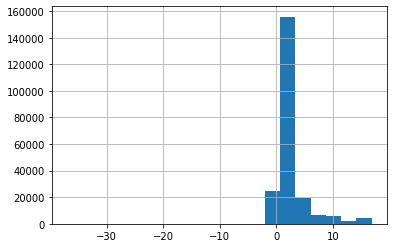

In [18]:
df.loc[df["has_possession"], "x_from_scrimmage"].hist(bins=20)

<AxesSubplot:>

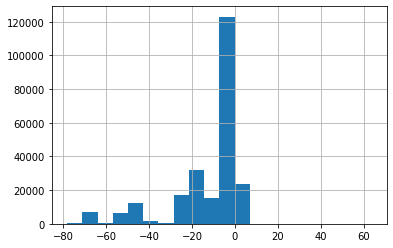

In [19]:
df.loc[~df["has_possession"], "x_from_scrimmage"].hist(bins=20)

In [20]:
# offensive players should all be greater than 0 at the start of the play
# some aren't, let's set the ones greater than a yard off to 0
df.loc[
    (df["x_from_scrimmage"] < -1) & (df["has_possession"]), "x_from_scrimmage"
] = 0

# defensive players should all be less than 0 at the start of the play
# some aren't, let's set the ones greater than a yard off to 0
df.loc[
    (df["x_from_scrimmage"] > 1) & (~df["has_possession"]), "x_from_scrimmage"
] = 0

df["x_from_scrimmage_abs"] = df["x_from_scrimmage"].abs()


In [21]:
# defense
defense_df = df.loc[~df["has_possession"]].copy()

# offense
offense_df = df.loc[df["has_possession"]].copy()


In [26]:
def_min_x = defense_df["x_from_scrimmage_abs"].min()
def_max_x = defense_df["x_from_scrimmage_abs"].max()

off_min_x = offense_df["x_from_scrimmage_abs"].min()
off_max_x = offense_df["x_from_scrimmage_abs"].max()

print(def_min_x, def_max_x)
print(off_min_x, off_max_x)

0.0 78.15
0.0 16.86


In [27]:
x_dim = 100 // 2 
y_dim = 53 // 2

defense_x_range = np.linspace(def_min_x, def_max_x, int(x_dim))
offense_x_range = np.linspace(off_min_x, off_max_x, int(x_dim))

y_range = np.linspace(0, 53, y_dim)


In [28]:
print(x_dim, y_dim)

50 26


In [29]:
def get_closest(array, values):
    # make sure array is a numpy array
    array = np.array(array)

    # get insert positions
    idxs = np.searchsorted(array, values, side="left")

    # find indexes where previous index is closer
    prev_idx_is_less = (idxs == len(array)) | (
        np.fabs(values - array[np.maximum(idxs - 1, 0)])
        < np.fabs(values - array[np.minimum(idxs, len(array) - 1)])
    )
    idxs[prev_idx_is_less] -= 1

    # this returns the closest value from linspace
    #return array[idxs]

    # this returns the index of the closest value from linspace, which is really all we need, I think
    return idxs


In [30]:
defense_df["x_transformed"] = get_closest(
    defense_x_range, defense_df["x_from_scrimmage_abs"]
)
defense_df["y_transformed"] = get_closest(y_range, defense_df["y_norm"])

offense_df["x_transformed"] = get_closest(
    offense_x_range, offense_df["x_from_scrimmage_abs"]
)
offense_df["y_transformed"] = get_closest(y_range, offense_df["y_norm"])


In [228]:
# Set the field to be a grid
empty_field = np.zeros((y_dim, x_dim))

In [229]:
def populate_field(gbdf, binary=False):
    """returns an array (field) with the dimensions (x_dim, y_dim)
    populated with players locations at each x,y coordinate

    Args:
        gbdf pandas DataFrame: a groupby dataframe of the play dataframe
        binary bool: if True, will return a binary field with 1s where players are, else sum up the number of players
    """
    # remove the football from the field
    gbdf = gbdf.loc[gbdf["team"] != "football"]
    # copy the empty field to populate it
    populated_field = empty_field.copy()
    x_idxs = gbdf["x_transformed"].values
    y_idxs = gbdf["y_transformed"].values
    if binary is True:
        populated_field[y_idxs, x_idxs] = 1
    else:
        # results are accumulated for results w/ more than one index :mind_blown:
        np.add.at(populated_field, (y_idxs, x_idxs), 1)

    # assert populated_field.sum() == 11
    # if populated_field.sum() != 11:
    #     print(populated_field.sum())
    return populated_field.flatten()

In [230]:
# boolean field
defense_sparse = defense_df.loc[defense_df["team"] != "football"].groupby(["gameId", "playId"]).apply(populate_field, binary=True)
offense_sparse = offense_df.loc[offense_df["team"] != "football"].groupby(["gameId", "playId"]).apply(populate_field, binary=True)

In [231]:
# How lossy was the transformation to subspace?
# Of ~20,000 plays, how many mapped all 11 players uniquely?

# this was from .sum()
defense_sparse.apply(lambda row: row.sum()).value_counts()

11.0    9864
10.0    2998
9.0     2637
8.0     2546
7.0     1622
6.0      302
5.0       10
dtype: int64

In [232]:
# How lossy was the transformation to subspace?
# Of ~20,000 plays, how many mapped all 11 players uniquely?
offense_sparse.apply(lambda row: row.sum()).value_counts()

11.0    11236
10.0     5967
9.0      2297
8.0       444
7.0        34
4.0         1
dtype: int64

In [233]:
# # boolean field
# defense_sparse = defense_df.loc[defense_df["team"] != "football"].groupby(["gameId", "playId"]).apply(populate_field)
# offense_sparse = offense_df.loc[offense_df["team"] != "football"].groupby(["gameId", "playId"]).apply(populate_field)

In [234]:
# womp womp this won't finish
# defense_sparse = pd.DataFrame(defense_sparse.tolist(), index=defense_sparse.index)

In [235]:
# field where the counts represent the number of players at each x,y coordinate
defense_sparse = defense_df.loc[defense_df["team"] != "football"].groupby(["gameId", "playId", "specialTeamsPlayType", "has_possession"]).apply(populate_field, binary=False)
offense_sparse = offense_df.loc[offense_df["team"] != "football"].groupby(["gameId", "playId", "specialTeamsPlayType", "has_possession"]).apply(populate_field, binary=False)

In [236]:
# better be all 11
defense_sparse.apply(lambda row: row.sum()).value_counts()

11.0    19979
dtype: int64

In [237]:
# better be all 11 
offense_sparse.apply(lambda row: row.sum()).value_counts()

11.0    19979
dtype: int64

In [238]:
defense_play_arrays = defense_sparse.copy()
offense_play_arrays = offense_sparse.copy()

In [239]:
# name the pandas series so we can merge them
defense_play_arrays.name = "normalized_player_locations"
offense_play_arrays.name = "normalized_player_locations"

In [240]:
defense_play_arrays = defense_play_arrays.to_frame()
offense_play_arrays = offense_play_arrays.to_frame()

## Cluster formations!

In [241]:
defense_players_df = pd.DataFrame(
    defense_play_arrays["normalized_player_locations"].tolist(),
    index=defense_play_arrays.index,
)
offense_players_df = pd.DataFrame(
    offense_play_arrays["normalized_player_locations"].tolist(),
    index=offense_play_arrays.index,
)


In [242]:
# PUNT
defense_punt = defense_players_df.loc[
    defense_players_df.index.get_level_values("specialTeamsPlayType") == "Punt"
]
offense_punt = offense_players_df.loc[
    offense_players_df.index.get_level_values("specialTeamsPlayType") == "Punt"
]

# KICKOFF
defense_kickoff = defense_players_df.loc[
    defense_players_df.index.get_level_values("specialTeamsPlayType")
    == "Kickoff"
]
offense_kickoff = offense_players_df.loc[
    offense_players_df.index.get_level_values("specialTeamsPlayType")
    == "Kickoff"
]

# EXTRA POINT
defense_extra_point = defense_players_df.loc[
    defense_players_df.index.get_level_values("specialTeamsPlayType")
    == "Extra Point"
]
offense_extra_point = offense_players_df.loc[
    offense_players_df.index.get_level_values("specialTeamsPlayType")
    == "Extra Point"
]

# FIELD GOAL
defense_field_goal = defense_players_df.loc[
    defense_players_df.index.get_level_values("specialTeamsPlayType")
    == "Field Goal"
]
offense_field_goal = offense_players_df.loc[
    offense_players_df.index.get_level_values("specialTeamsPlayType")
    == "Field Goal"
]


In [243]:
def umapify(
    play_type_df,
    umap__n_neighbors=133,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
):
    """Apply UMAP and HDBSCAN to a DataFrame of player locations

    Args:
        play_type_df (DataFrame): A DataFrame of normalized player locations

    Returns:
        pandas DataFrame: A DataFrame of player locations in UMAP space
    """

    umap = UMAP(
        n_neighbors=umap__n_neighbors,
        min_dist=0,
        metric="euclidean",
        n_components=2,
    )

    umapdf = umap.fit_transform(play_type_df)
    umapdf = pd.DataFrame(umapdf, index=play_type_df.index)
    umapdf.columns = ["component_1", "component_2"]


    umapdf = umapdf.merge(
        # note this is the original df, which has play type
        # keeps only one record per play, which is fine for play-level data
        df.drop_duplicates(subset=["gameId", "playId"]).set_index(
            ["gameId", "playId", "specialTeamsPlayType", "has_possession"]
        )[
            ["specialTeamsResult"]
            + scouting.drop(columns=["gameId", "playId"]).columns.tolist()
        ],
        left_index=True,
        right_index=True,
        how="left",
    )

    labels = hdbscan.HDBSCAN(
        min_samples=hdbscan__min_samples,
        min_cluster_size=hdbscan__min_cluster_size,
    ).fit_predict(umapdf[["component_1", "component_2"]])

    umapdf["cluster"] = labels

    return umapdf


In [244]:
defense_punt_umap = umapify(
    defense_punt,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
)
offense_punt_umap = umapify(
    offense_punt,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
)

defense_kickoff_umap = umapify(
    defense_kickoff,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=15,
    hdbscan__min_samples=5,
)
offense_kickoff_umap = umapify(
    offense_kickoff,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
)

defense_extra_point_umap = umapify(
    defense_extra_point,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
)
offense_extra_point_umap = umapify(
    offense_extra_point,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
)

defense_field_goal_umap = umapify(
    defense_field_goal,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
)
offense_field_goal_umap = umapify(
    offense_field_goal,
    umap__n_neighbors=75,
    hdbscan__min_cluster_size=50,
    hdbscan__min_samples=15,
)


In [245]:
def plot_clusters(umapdf):
    fig, ax = plt.subplots(figsize=(8, 8))
    for cluster in sorted(umapdf.cluster.unique()):
        ax.scatter(
            umapdf.loc[umapdf.cluster == cluster, "component_1"],
            umapdf.loc[umapdf.cluster == cluster, "component_2"],
            s=5,
            alpha=0.5,
            label=cluster,
            color=sns.color_palette("tab20")[cluster],
        )
    ax.grid();
    ax.legend();

    if umapdf.index.get_level_values("has_possession").unique()[0]:
        side = "Offense"
    else:
        side = "Defense"
    n_plays = umapdf.shape[0]
    play_type = umapdf.index.get_level_values("specialTeamsPlayType").unique()[0]
    ax.set_title(f"Clusters of {n_plays} {side} {play_type} Plays");

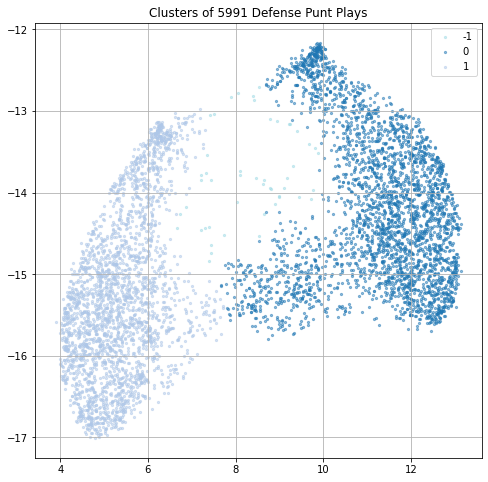

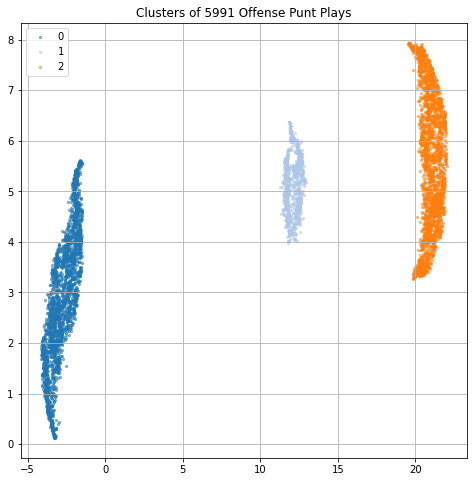

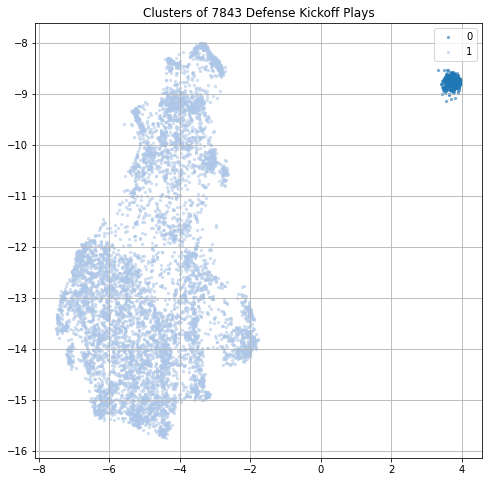

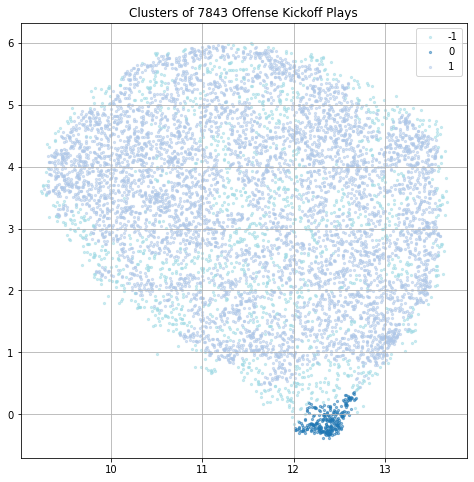

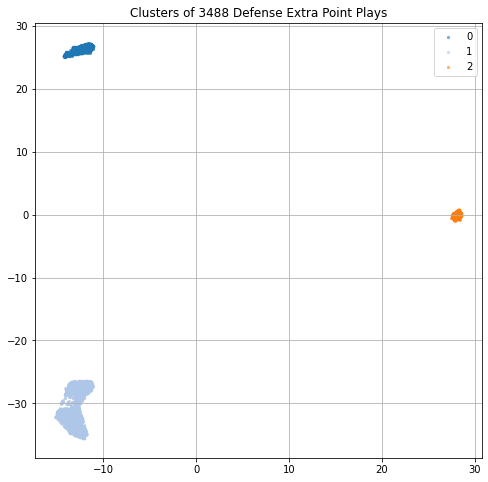

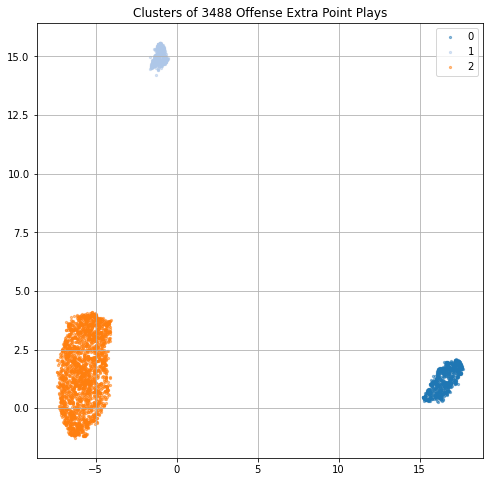

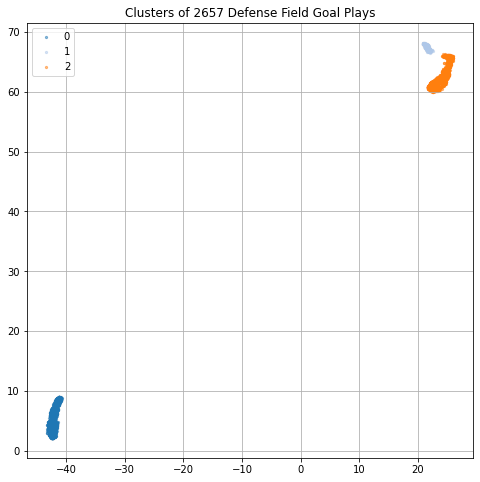

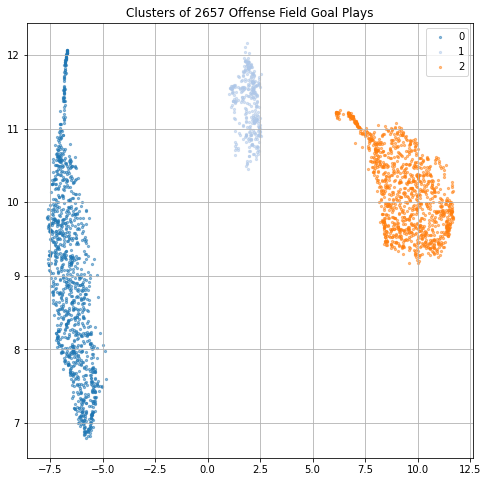

In [246]:
for play_type_umap in [
    defense_punt_umap,
    offense_punt_umap,
    defense_kickoff_umap,
    offense_kickoff_umap,
    defense_extra_point_umap,
    offense_extra_point_umap,
    defense_field_goal_umap,
    offense_field_goal_umap,
]:  
    plot_clusters(play_type_umap)


## Visualize the mean arrays in the subspace

In [247]:
offense_punt_clusters = offense_punt.merge(
    offense_punt_umap["cluster"], left_index=True, right_index=True
)
offense_punt_clusters_reshaped = offense_punt_clusters.groupby("cluster").apply(
    lambda row: row[range(1300)].mean()
)
offense_punt_clusters_reshaped = offense_punt_clusters_reshaped[
    range(1300)
].apply(lambda row: row.values.reshape(y_dim, x_dim), axis=1)


# normalize y too by taking the y dist from the ball?!?!?!

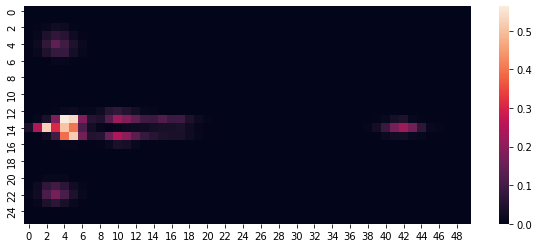

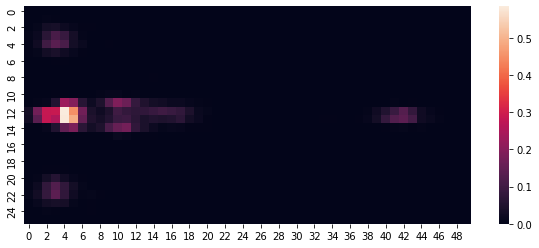

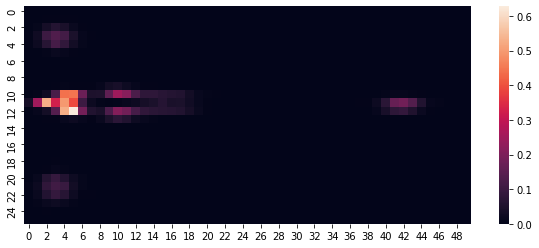

In [248]:
# is this just different hash marks and center


for cluster, cluster_array in offense_punt_clusters_reshaped.iteritems():
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.heatmap(cluster_array, ax=ax)

## Visualize a few plays

In [146]:
def plot_play(gameid, playid, normdf):
    play = normdf.loc[(normdf["gameId"] == gameid) & (normdf["playId"] == playid)]

    fig = plt.figure(figsize=(12, 5))
    ax = plt.axes(xlim=(0, 120), ylim=(0, 53))


    football = play.loc[play["team"] == "football"]

    ax.scatter(play["x_from_scrimmage_abs"], play["y_norm"], color="#fb8500", s=150)
    ax.scatter(
        football["x_from_scrimmage_abs"],
        football["y_norm"],
        marker=football_marker,
        color="brown",
        s=250,
    )

    ax.set_yticks([])
    ax.set_xticks([30, 60, 90])
    ax.set_xticklabels(["20", "50", "20"])
    ax.vlines(10, 0, 53.3, color="black", linestyle="-", alpha=0.5)
    ax.vlines(60, 0, 53.3, color="black", linestyle="-", alpha=0.5)
    ax.vlines(110, 0, 53.3, color="black", linestyle="-", alpha=0.5)


    

Plot a few plays

Cluster 0
Cluster 1


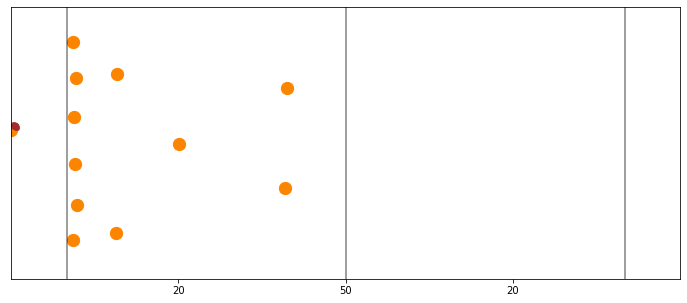

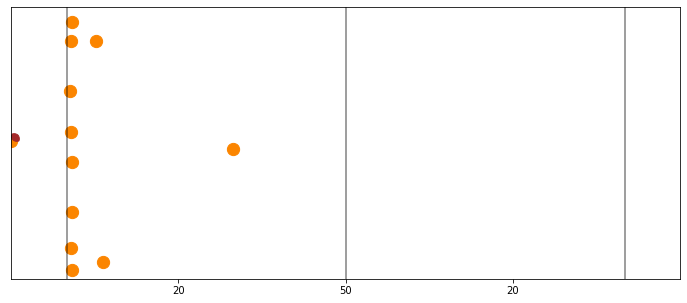

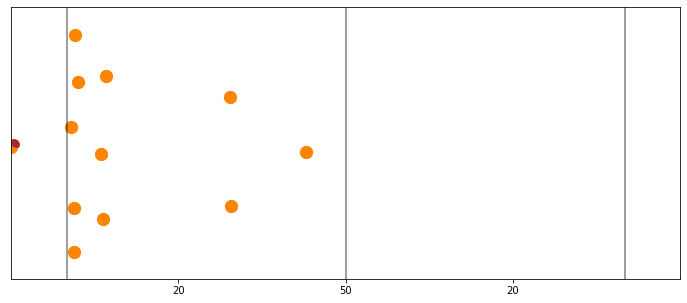

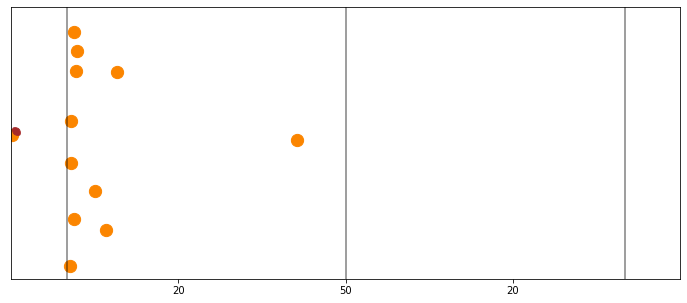

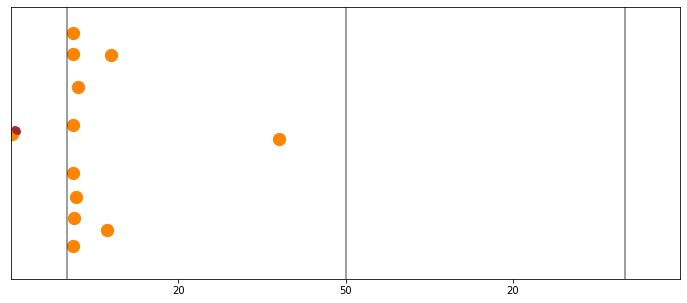

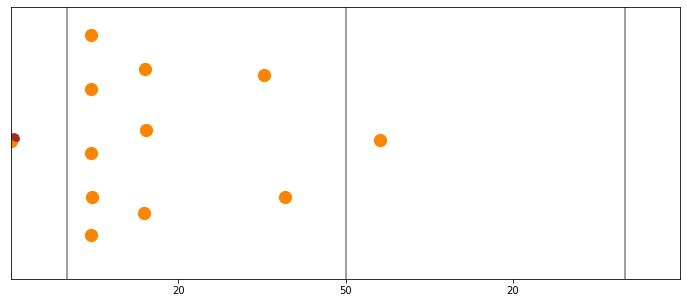

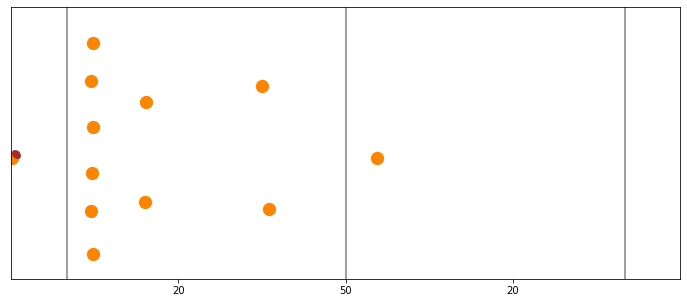

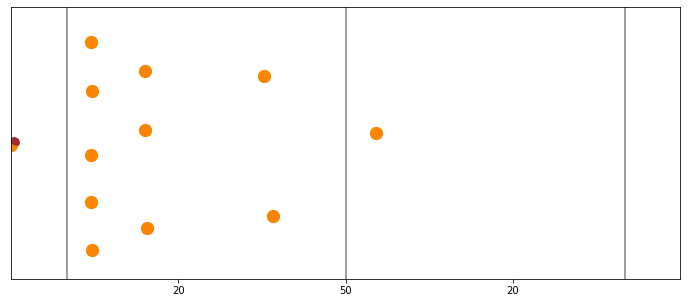

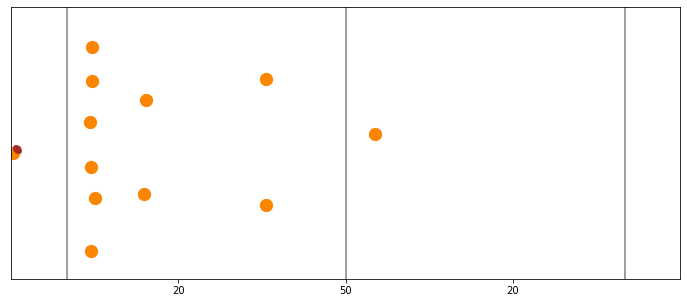

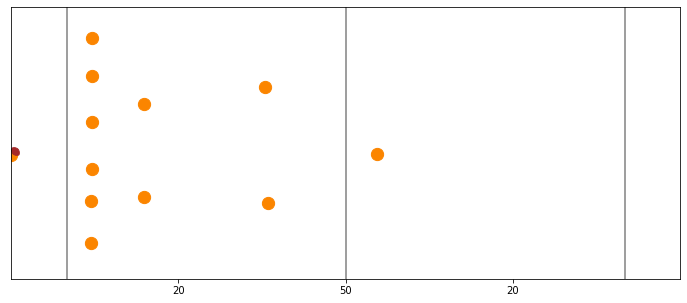

In [169]:
for cluster in sorted(defense_kickoff_umap.cluster.unique()):
    print(f"Cluster {cluster}")
    cluster_plays = defense_kickoff_umap.loc[defense_kickoff_umap["cluster"] == cluster].reset_index()
    gameids = cluster_plays["gameId"]
    playids = cluster_plays["playId"]
    
    for i, (gameid, playid) in enumerate(zip(gameids, playids)):
        if i == 5:
            break
        plot_play(gameid, playid, defense_df)
        #     # plt.savefig(f"punt_cluster_{cluster}_{gameid}_{playid}.png")


# Visualize the clusters

## Kickoff -- formation dectection comparison offense

In [155]:
scouting["kickoffReturnFormation"].value_counts()

8-0-2     7224
8-0-1      471
6-2-2       39
5-3-2       32
7-0-3       17
6-0-3       13
9-0-1       12
6-0-4       11
10-0-0       7
7-1-2        5
8-1-0        4
8-1-1        4
8-0-3        1
5-0-4        1
9-0-0        1
9-1-0        1
Name: kickoffReturnFormation, dtype: int64

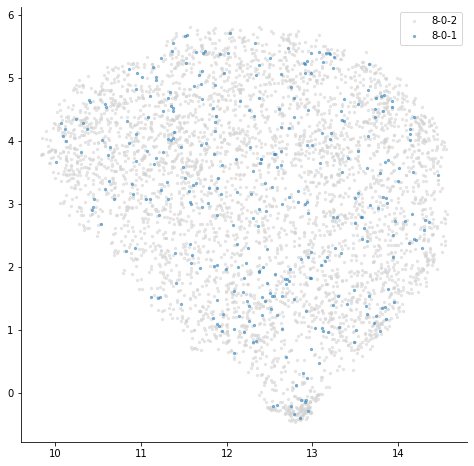

In [158]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    offense_kickoff_umap.loc[
        offense_kickoff_umap["kickoffReturnFormation"] == "8-0-2", "component_1"
    ],
    offense_kickoff_umap.loc[
        offense_kickoff_umap["kickoffReturnFormation"] == "8-0-2", "component_2"
    ],
    s=5,
    alpha=0.5,
    color="lightgrey",
    label="8-0-2",
)
ax.scatter(
    offense_kickoff_umap.loc[
        offense_kickoff_umap["kickoffReturnFormation"] == "8-0-1", "component_1"
    ],
    offense_kickoff_umap.loc[
        offense_kickoff_umap["kickoffReturnFormation"] == "8-0-1", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="8-0-1",
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend();


# Kickoff - kickType defense

In [159]:
defense_kickoff_umap["kickType"].value_counts()

D    2900
F     125
O     103
P      86
Q      54
K      27
S       4
B       1
Name: kickType, dtype: int64

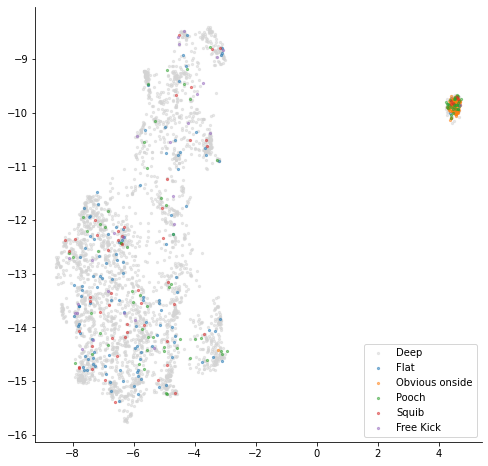

In [161]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "D", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "D", "component_2"
    ],
    s=5,
    alpha=0.5,
    color="lightgrey",
    label="Deep",
)

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "F", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "F", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Flat",
)

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "O", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "O", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Obvious onside",
)

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "P", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "P", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Pooch",
)

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "Q", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "Q", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Squib",
)

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "K", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "K", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Free Kick",
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend();


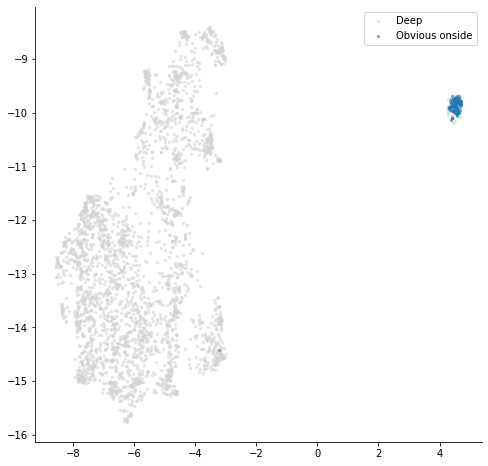

In [162]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "D", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "D", "component_2"
    ],
    s=5,
    alpha=0.5,
    color="lightgrey",
    label="Deep",
)

ax.scatter(
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "O", "component_1"
    ],
    defense_kickoff_umap.loc[
        defense_kickoff_umap["kickType"] == "O", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Obvious onside",
)


# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend();


## Punt -- Blocked punts defense

In [153]:
defense_punt_umap["specialTeamsResult"].value_counts()

Return                      711
Fair Catch                  510
Downed                      288
Out of Bounds               201
Touchback                   120
Muffed                       47
Non-Special Teams Result     21
Blocked Punt                 13
Name: specialTeamsResult, dtype: int64

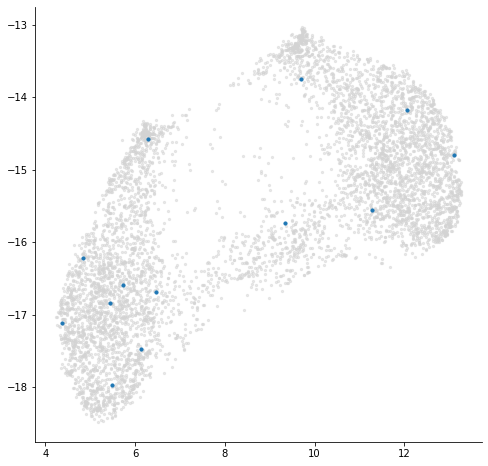

In [163]:
fig, ax = plt.subplots(figsize=(8, 8))

result_type = "Blocked Punt"

ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] != result_type, "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] != result_type, "component_2"
    ],
    s=5,
    alpha=0.5,
    color="lightgrey",
    label="All punt results (not blocked)",
)
ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] == result_type, "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["specialTeamsResult"] == result_type, "component_2"
    ],
    s=10,
    label="Blocked Punt",
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


## Punt -- Blocked punts offense

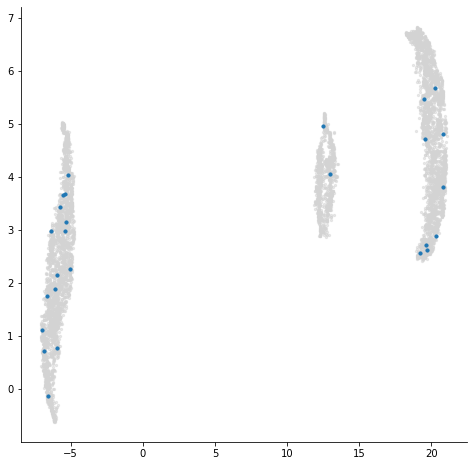

In [164]:
fig, ax = plt.subplots(figsize=(8, 8))

result_type = "Blocked Punt"

ax.scatter(
    offense_punt_umap.loc[
        offense_punt_umap["specialTeamsResult"] != result_type, "component_1"
    ],
    offense_punt_umap.loc[
        offense_punt_umap["specialTeamsResult"] != result_type, "component_2"
    ],
    s=5,
    alpha=0.5,
    color="lightgrey",
    label="All punt results (not blocked)",
)
ax.scatter(
    offense_punt_umap.loc[
        offense_punt_umap["specialTeamsResult"] == result_type, "component_1"
    ],
    offense_punt_umap.loc[
        offense_punt_umap["specialTeamsResult"] == result_type, "component_2"
    ],
    s=10,
    label="Blocked Punt",
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


# kickType for punts

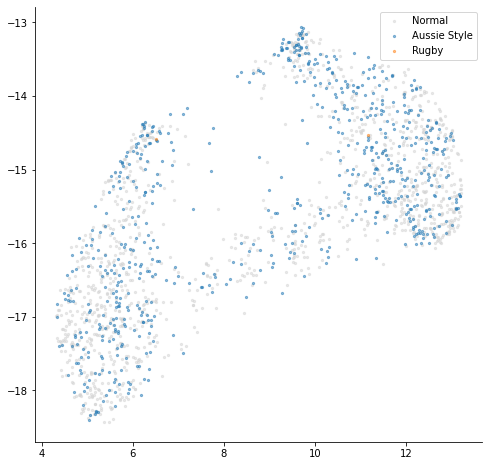

In [167]:
fig, ax = plt.subplots(figsize=(8, 8))

# normal style
ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["kickType"] == "N", "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["kickType"] == "N", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Normal",
    color="lightgrey",
)
# aussie style
ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["kickType"] == "A", "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["kickType"] == "A", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Aussie Style"
)
ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["kickType"] == "R", "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["kickType"] == "R", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Rugby"
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend();


## punt -- kick ContactType Defense

In [142]:
defense_punt_umap["kickContactType"].value_counts(dropna=False)

NaN     4114
CC      1161
BF       361
OOB      105
BB       100
CFFG      53
MBDR      41
DEZ       19
KTC       11
KTB        7
KTF        5
BC         5
MBC        3
BOG        3
ICC        3
Name: kickContactType, dtype: int64

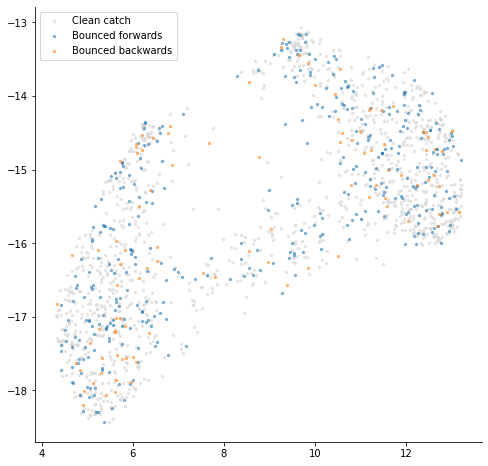

In [152]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["kickContactType"] == "CC", "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["kickContactType"] == "CC", "component_2"
    ],
    s=5,
    alpha=0.5,
    color="lightgrey",
    label="Clean catch",
)
# bounced forwards
ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["kickContactType"] == "BF", "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["kickContactType"] == "BF", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Bounced forwards",
)
# bounced backwards
ax.scatter(
    defense_punt_umap.loc[
        defense_punt_umap["kickContactType"] == "BB", "component_1"
    ],
    defense_punt_umap.loc[
        defense_punt_umap["kickContactType"] == "BB", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Bounced backwards",
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend();


## punts -- kickContactType offense

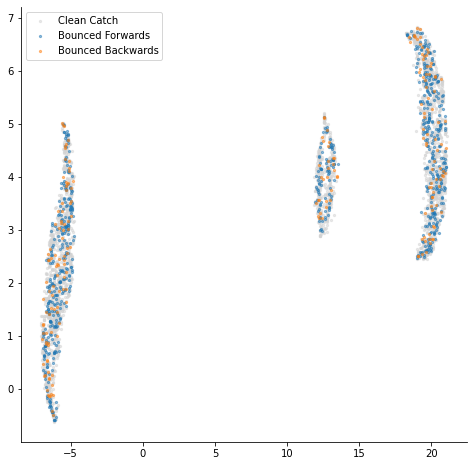

In [151]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(
    offense_punt_umap.loc[
        offense_punt_umap["kickContactType"] == "CC", "component_1"
    ],
    offense_punt_umap.loc[
        offense_punt_umap["kickContactType"] == "CC", "component_2"
    ],
    s=5,
    alpha=0.5,
    color="lightgrey",
    label="Clean Catch",
)
# bounced forwards
ax.scatter(
    offense_punt_umap.loc[
        offense_punt_umap["kickContactType"] == "BF", "component_1"
    ],
    offense_punt_umap.loc[
        offense_punt_umap["kickContactType"] == "BF", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Bounced Forwards",
)
# bounced backwards
ax.scatter(
    offense_punt_umap.loc[
        offense_punt_umap["kickContactType"] == "BB", "component_1"
    ],
    offense_punt_umap.loc[
        offense_punt_umap["kickContactType"] == "BB", "component_2"
    ],
    s=5,
    alpha=0.5,
    label="Bounced Backwards",
)

# Hide the right and top spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend();
